In [103]:
import warnings
warnings.filterwarnings('ignore')
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import linear_model 
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from numba import jit


# Importation  et retraitement des données

In [66]:
df = pd.read_csv("Data_Satisfaction_retraitement4.csv")

df = df.dropna(axis = 0, how = "all", subset =["Commentaires_reduit"])

#création de l'ensemble de target "y"
y = df["star"]

#Création du numpy array comprenant l'ensemble des méta-donnée
Meta_Matrix = df.drop(["star","Commentaires_reduit"], axis =1).to_numpy()

In [67]:
#transformation des notes sur une echelle de 0 à 4 pour facilité l'implemenation dans un model de reseau de neurone 
y = y.replace(to_replace = [1,2,3,4,5], value = [0,1,2,3,4])

In [87]:
#vectorization des commentaires par l'algorithme TF-IDF
vectorizer = TfidfVectorizer(min_df = 150)
Com_Matrix = vectorizer.fit_transform(df["Commentaires_reduit"]).todense()

#concatenation des deux matrices pour obtenir une matrice globale méta-donnée + commentaires vectorisés.
X = np.concatenate([Com_Matrix,Meta_Matrix],axis=1)

In [88]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 100)

# Modeles de machine learning 

Nous avons testé nos données avec les modeles suivant:
   - Gradiant Booster
   - Random Forest
   - Support Vector Machine
   - Logistic Regression
   
Les meilleurs parametres de ces modeles ont été établis précédemment avec un model GridSeachCV.

In [97]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.3, max_depth=1, random_state=0).fit(X_train, y_train)
print("gb score :", gb.score(X_test,y_test))
rf = RandomForestClassifier(max_features = "log2", random_state= 0).fit(X_train, y_train)
print("rf score :", rf.score(X_test,y_test))
svc = SVC(C= 0.1 , kernel ="linear", random_state= 0).fit(X_train, y_train)
print("scv score :", svc.score(X_test,y_test))
rl = linear_model.LogisticRegression(C = 0.1, max_iter = 100, random_state= 0).fit(X_train, y_train)
print("rl score :", rl.score(X_test,y_test))

gb score : 0.7007211538461539
rf score : 0.6911057692307693
scv score : 0.6715745192307693
rl score : 0.6974158653846154


In [98]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('gb', gb), ('rf', rf), ('svc', svc), ('lr', rl)], voting='hard').fit(X_train,y_train) 

In [100]:
print("vclf score :", vclf.score(X_test,y_test))

vclf score : 0.6971153846153846


La meilleur précision obtenue sur l'ensemble de test provient du modele GradientBoosting.

Affichons son rapport de classification ainsi que la matrice de confusion

In [104]:
y_pred = gb.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       980
           1       0.25      0.09      0.14       255
           2       0.38      0.23      0.28       315
           3       0.46      0.51      0.48       608
           4       0.80      0.89      0.84      1170

    accuracy                           0.70      3328
   macro avg       0.54      0.53      0.52      3328
weighted avg       0.66      0.70      0.68      3328

[[ 884   24   21   38   13]
 [  88   24   44   88   11]
 [  29   28   72  155   31]
 [  25   19   49  310  205]
 [  40    2    5   81 1042]]


# Reseau de neurone Dense

### Création, compilation et entrainement du modèle

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense ,  Dropout
from tensorflow.keras.models import Model

#creation du model avec 2 couche Dense
model = Sequential()
model.add(Input(shape = X_train.shape[1]))
model.add(Dense(6, activation="tanh"))
model.add(Dense(5, activation ="softmax"))

# nous avons plusieurs catégories dans la variable cible, nous choisisons donc la fonction de perte 
#"sparse_categorical_crossentropy" lors de la compilation du model.
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [93]:
#creation de fonction callbacks pour optimiser le temps d'apprentissage

#une fonction permettant de réuidre le learning rate en fonction de l'évolution de la "val_accuracy"
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor = 'val_accuracy',
                        min_delta = 0.001,
                        patience = 10,
                        factor = 0.5, 
                        cooldown = 5,
                        verbose = 1)

#une fonction permettant de stoper l'entrainement si l'évolution de la "val_accuracy" ne depasse plus un certain seuil
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor = 'val_accuracy',
                    min_delta = 0.0001,
                    patience = 10,
                    verbose = 1,
                    restore_best_weights = True)

In [94]:
#entrainement du modèle
model_history = model.fit (X_train, y_train, epochs = 50, batch_size = 200, validation_split = 0.2, callbacks= [reducelr,earlystop])

Epoch 1/50
54/54 [==============================] - 0s 2ms/step - loss: 0.7273 - accuracy: 0.7120 - val_loss: 0.7879 - val_accuracy: 0.6942 - lr: 5.0000e-04
Epoch 2/50
54/54 [==============================] - 0s 2ms/step - loss: 0.7247 - accuracy: 0.7135 - val_loss: 0.7867 - val_accuracy: 0.6931 - lr: 5.0000e-04
Epoch 3/50
54/54 [==============================] - 0s 2ms/step - loss: 0.7223 - accuracy: 0.7134 - val_loss: 0.7859 - val_accuracy: 0.6931 - lr: 5.0000e-04
Epoch 4/50
54/54 [==============================] - 0s 2ms/step - loss: 0.7201 - accuracy: 0.7134 - val_loss: 0.7847 - val_accuracy: 0.6916 - lr: 5.0000e-04
Epoch 5/50
54/54 [==============================] - 0s 2ms/step - loss: 0.7179 - accuracy: 0.7146 - val_loss: 0.7837 - val_accuracy: 0.6923 - lr: 5.0000e-04
Epoch 6/50
54/54 [==============================] - 0s 2ms/step - loss: 0.7158 - accuracy: 0.7142 - val_loss: 0.7828 - val_accuracy: 0.6935 - lr: 5.0000e-04
Epoch 7/50
54/54 [==============================] - 0s 2ms

### Evaluation du modèle

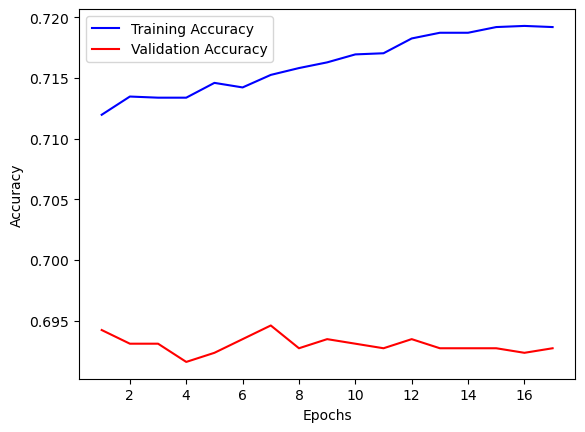

In [95]:
import matplotlib.pyplot as plt

train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entraînement
plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , max(model_history.epoch)+2, 1),
         model_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [96]:
#affichage d'un rapport de classification ainsi que d'une matrice de confusion

test_pred = model.predict(X_test)
y_test_class = y_test
y_pred_class = np.argmax(test_pred,axis=1)

print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class)) 

104/104 [==============================] - 0s 591us/step
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       980
           1       0.31      0.10      0.15       255
           2       0.37      0.29      0.33       315
           3       0.46      0.50      0.48       608
           4       0.81      0.85      0.83      1170

    accuracy                           0.70      3328
   macro avg       0.55      0.53      0.53      3328
weighted avg       0.67      0.70      0.68      3328

[[900  22  25  26   7]
 [104  25  60  64   2]
 [ 42  22  92 137  22]
 [ 30  10  57 304 207]
 [ 32   2  12 125 999]]


# Conclusion

Les performances de notre reseau de neurones sont assez proche du modeles de gradient boosting. Nous obtenons un score de précision moyen de 67% selon les rapports de classification. Les deux modéles ont du mal à prédire les classes 1,2 et 3, qui correspondents aux notes intermédiaire, ou la précision pour ces classes tombe jusqu'à 31%, juste un peu mieux qu'une prédiction aléatoire.

Afin d'améliorer la prédiction de nos modèles il serait interessant de regrouper les classes 1,2 et 3 en une seule et même classe. Nous aurions cette fois à faire à une modelisation en 3 classes.
